# Multi-Agent Applications: Building Agent Teams with LangGraph

In this notebook, we'll explore **multi-agent systems** - applications where multiple specialized agents collaborate to solve complex tasks. We'll build on our LangGraph foundation from Session 4 and create agent teams for our Personal Wellness Assistant.

**Learning Objectives:**
- Understand when and why to use multi-agent systems
- Master the Supervisor pattern for orchestrating agent teams
- Implement Agent Handoffs for dynamic task routing
- Use Tavily Search for web research capabilities
- Apply context engineering principles to optimize agent performance
- Visualize and debug multi-agent systems with LangSmith

## Table of Contents:

- **Breakout Room #1:** Multi-Agent Fundamentals & Supervisor Pattern
  - Task 1: Dependencies & Environment Setup
  - Task 2: Understanding Multi-Agent Systems
  - Task 3: Building a Supervisor Agent Pattern
  - Task 4: Adding Tavily Search for Web Research
  - Question #1 & Question #2
  - Activity #1: Add a Custom Specialist Agent

- **Breakout Room #2:** Handoffs & Context Engineering
  - Task 5: Agent Handoffs Pattern
  - Task 6: Building a Wellness Agent Team
  - Task 7: Context Engineering & Optimization
  - Task 8: Visualizing and Debugging with LangSmith
  - Question #3 & Question #4
  - Activity #2: Implement Hierarchical Teams

---
# 🤝 Breakout Room #1
## Multi-Agent Fundamentals & Supervisor Pattern

## Task 1: Dependencies & Environment Setup

Before we begin, make sure you have:

1. **API Keys** for:
   - OpenAI (for GPT-5.2 supervisor and GPT-4o-mini specialist agents)
   - Tavily (free tier at [tavily.com](https://www.tavily.com/))
   - LangSmith (optional, for tracing)

2. **Dependencies installed** via `uv sync`

**Models Used:**
- **GPT-5.2**: Supervisor/orchestrator agents (better reasoning for routing decisions)
- **GPT-4o-mini**: Specialist agents (cost-effective for domain-specific tasks)

**Documentation:**
- [Tavily Search API](https://docs.tavily.com/)

In [5]:
# Core imports
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal, Sequence
import operator

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [6]:
import os
import openai
from getpass import getpass
from dotenv import load_dotenv
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
# openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key
#print("API Key: ", os.environ["OPENAI_API_KEY"])
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
# Optional: LangSmith for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Multi-Agent Applications - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - Multi-Agent Applications - f67edba2


In [7]:
# Tavily API Key for web search


In [8]:
# Initialize LLMs - GPT-5.2 for supervisors, GPT-4o-mini for specialists
from langchain_openai import ChatOpenAI

# Supervisor model - better reasoning for routing and orchestration
supervisor_llm = ChatOpenAI(model="gpt-5.2", temperature=0)

# Specialist model - cost-effective for domain-specific tasks
specialist_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Test both models
print("Testing models...")
supervisor_response = supervisor_llm.invoke("Say 'Supervisor ready!' in exactly 2 words.")
specialist_response = specialist_llm.invoke("Say 'Specialist ready!' in exactly 2 words.")

print(f"Supervisor (GPT-5.2): {supervisor_response.content}")
print(f"Specialist (GPT-4o-mini): {specialist_response.content}")

Testing models...
Supervisor (GPT-5.2): Supervisor ready!
Specialist (GPT-4o-mini): Specialist ready!


## Task 2: Understanding Multi-Agent Systems

### When to Use Multi-Agent Systems

Before building multi-agent systems, ask yourself:

> **"Do I really need several specialized dynamic reasoning machines collaborating to solve this task more effectively than a single agent could?"**

Multi-agent systems are useful when:
1. **Tool/responsibility grouping**: Different tasks require different expertise
2. **Prompt separation**: Different agents need different instructions/few-shot examples
3. **Piecewise optimization**: Easier to improve individual components

### Key Multi-Agent Patterns

| Pattern | Description | Use Case |
|---------|-------------|----------|
| **Supervisor** | Central orchestrator routes to specialist agents | Task delegation, quality control |
| **Handoffs** | Agents transfer control to each other | Conversation flows, expertise routing |
| **Hierarchical** | Supervisors manage teams of agents | Large-scale systems, departments |
| **Network/Swarm** | Agents communicate freely | Collaborative problem-solving |

### Context Engineering Principles

From leading practitioners:

- **Dex Horthy (12-Factor Agents)**: "Own your context window and treat it like prime real estate"
- **swyx (Agent Engineering)**: "Agent reliability = great context construction"
- **Chroma (Context Rot)**: "Longer ≠ better when it comes to context"

**Documentation:**
- [Building Effective Agents (Anthropic)](https://www.anthropic.com/engineering/building-effective-agents)
- [Don't Build Multi-Agents (Cognition)](https://cognition.ai/blog/dont-build-multi-agents)
- [12-Factor Agents](https://github.com/humanlayer/12-factor-agents)

## Task 3: Building a Supervisor Agent Pattern

The **Supervisor Pattern** uses a central agent to:
1. Analyze incoming requests
2. Route to the appropriate specialist agent
3. Aggregate and refine responses

```
                    ┌─────────────────┐
                    │   Supervisor    │
                    │   (Orchestrator)│
                    └────────┬────────┘
                             │
           ┌─────────────────┼─────────────────┐
           │                 │                 │
           ▼                 ▼                 ▼
    ┌────────────┐    ┌────────────┐    ┌────────────┐
    │  Exercise  │    │  Nutrition │    │   Sleep    │
    │   Agent    │    │   Agent    │    │   Agent    │
    └────────────┘    └────────────┘    └────────────┘
```

**Documentation:**
- [LangGraph Supervisor Tutorial](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)

In [9]:
# Import LangGraph and LangChain components
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.agents import create_agent  # LangChain 1.0 API
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

print("LangGraph and LangChain components imported!")

LangGraph and LangChain components imported!


In [10]:
# First, let's set up our RAG system for the wellness knowledge base
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Load and chunk the wellness document
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_documents(documents)

print(f"Loaded and split into {len(chunks)} chunks")

Loaded and split into 45 chunks


In [11]:
# Set up vector store
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_dim = len(embedding_model.embed_query("test"))

qdrant_client = QdrantClient(":memory:")
qdrant_client.create_collection(
    collection_name="wellness_multiagent",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE)
)

vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name="wellness_multiagent",
    embedding=embedding_model
)
vector_store.add_documents(chunks)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})
print(f"Vector store ready with {len(chunks)} documents")

Vector store ready with 45 documents


In [120]:
# Create specialized tools for each agent domain

@tool
def search_exercise_info(query: str) -> str:
    """Search for exercise, fitness, and workout information from the wellness knowledge base.
    Use this for questions about physical activity, workout routines, and exercise techniques.
    """
    results = retriever.invoke(f"exercise fitness workout {query}")
    if not results:
        return "No exercise information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_nutrition_info(query: str) -> str:
    """Search for nutrition, diet, and healthy eating information from the wellness knowledge base.
    Use this for questions about food, meal planning, and dietary guidelines.
    """
    results = retriever.invoke(f"nutrition diet food meal {query}")
    if not results:
        return "No nutrition information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_sleep_info(query: str) -> str:
    """Search for sleep, rest, and recovery information from the wellness knowledge base.
    Use this for questions about sleep quality, insomnia, and sleep hygiene.
    """
    results = retriever.invoke(f"sleep rest recovery insomnia {query}")
    if not results:
        return "No sleep information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_stress_info(query: str) -> str:
    """Search for stress management and mental wellness information from the wellness knowledge base.
    Use this for questions about stress, anxiety, mindfulness, and mental health.
    """
    results = retriever.invoke(f"stress mental wellness mindfulness anxiety {query}")
    if not results:
        return "No stress management information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_headache_info(query: str) -> str:
    """Search for headache  information from the wellness knowledge base.
    Use this for questions about headache, migraines, and headache relief.
    """
    results = retriever.invoke(f"headache migraines headache relief {query}")
    if not results:
        return "No headache care information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])


print("Specialist tools created!")

Specialist tools created!


In [13]:
# Create specialist agents using create_agent (LangChain 1.0 API)
# Each specialist uses GPT-4o-mini for cost efficiency

exercise_agent = create_agent(
    model=specialist_llm,
    tools=[search_exercise_info],
    system_prompt="You are an Exercise Specialist. Help users with workout routines, fitness tips, and physical activity guidance. Always search the knowledge base before answering. Be concise and helpful."
)

nutrition_agent = create_agent(
    model=specialist_llm,
    tools=[search_nutrition_info],
    system_prompt="You are a Nutrition Specialist. Help users with diet advice, meal planning, and healthy eating. Always search the knowledge base before answering. Be concise and helpful."
)

sleep_agent = create_agent(
    model=specialist_llm,
    tools=[search_sleep_info],
    system_prompt="You are a Sleep Specialist. Help users with sleep quality, insomnia, and rest optimization. Always search the knowledge base before answering. Be concise and helpful."
)

stress_agent = create_agent(
    model=specialist_llm,
    tools=[search_stress_info],
    system_prompt="You are a Stress Management Specialist. Help users with stress relief, mindfulness, and mental wellness. Always search the knowledge base before answering. Be concise and helpful."
)

headache_agent = create_agent(
    model=specialist_llm,
    tools=[search_headache_info],
    system_prompt="You are a headache Care Specialist. Help users with headache care, styling, and headache health. Always search the knowledge base before answering. Be concise and helpful."
)


print("Specialist agents created (using GPT-4o-mini with create_agent)!")

Specialist agents created (using GPT-4o-mini with create_agent)!


In [14]:
# Define the supervisor state and routing
from typing import List
from pydantic import BaseModel

# Define routing options - supervisor picks ONE specialist, then that specialist responds
class RouterOutput(BaseModel):
    """The supervisor's routing decision."""
    next: Literal["exercise", "nutrition", "sleep", "stress", "headache"]
    reasoning: str

class SupervisorState(TypedDict):
    """State for the supervisor multi-agent system."""
    messages: Annotated[list[BaseMessage], add_messages]
    next: str

print("Supervisor state defined!")

Supervisor state defined!


In [15]:
# Create the supervisor node (using GPT-5.2 for routing decisions)
from langchain_core.prompts import ChatPromptTemplate

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a Wellness Supervisor coordinating a team of specialist agents.

Your team:
- exercise: Handles fitness, workouts, physical activity, movement questions
- nutrition: Handles diet, meal planning, healthy eating, food questions
- sleep: Handles sleep quality, insomnia, rest, recovery questions
- stress: Handles stress management, mindfulness, mental wellness, anxiety questions
- headache: Handles headaches, migraines, headache relief questions

Based on the user's question, decide which ONE specialist should respond.
Choose the most relevant specialist for the primary topic of the question."""),
    ("human", "User question: {question}\n\nWhich specialist should handle this?")
])

# Create structured output for routing (using GPT-5.2)
routing_llm = supervisor_llm.with_structured_output(RouterOutput)

def supervisor_node(state: SupervisorState):
    """The supervisor decides which agent to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = supervisor_prompt.invoke({"question": user_question})
    result = routing_llm.invoke(prompt_value)
    
    print(f"[Supervisor GPT-5.2] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.next}

print("Supervisor node created (using GPT-5.2)!")

Supervisor node created (using GPT-5.2)!


In [16]:
# Create agent nodes that wrap the specialist agents

def create_agent_node(agent, name: str):
    """Create a node that runs a specialist agent and returns the final response."""
    def agent_node(state: SupervisorState):
        print(f"[{name.upper()} Agent] Processing request...")
        
        # Invoke the specialist agent with the conversation
        result = agent.invoke({"messages": state["messages"]})
        
        # Get the agent's final response
        agent_response = result["messages"][-1]
        
        # Add agent identifier to the response
        response_with_name = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{agent_response.content}",
            name=name
        )
        
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response_with_name]}
    
    return agent_node

# Create nodes for each specialist
exercise_node = create_agent_node(exercise_agent, "exercise")
nutrition_node = create_agent_node(nutrition_agent, "nutrition")
sleep_node = create_agent_node(sleep_agent, "sleep")
stress_node = create_agent_node(stress_agent, "stress")
headache_node = create_agent_node(headache_agent, "headache")
print("Agent nodes created!")

Agent nodes created!


In [17]:
# Build the supervisor graph
# KEY: Specialists go directly to END (no loop back to supervisor)

def route_to_agent(state: SupervisorState) -> str:
    """Route to the next agent based on supervisor decision."""
    return state["next"]

# Create the graph
supervisor_workflow = StateGraph(SupervisorState)

# Add nodes
supervisor_workflow.add_node("supervisor", supervisor_node)
supervisor_workflow.add_node("exercise", exercise_node)
supervisor_workflow.add_node("nutrition", nutrition_node)
supervisor_workflow.add_node("sleep", sleep_node)
supervisor_workflow.add_node("stress", stress_node)
supervisor_workflow.add_node("headache", headache_node)
# Add edges: START -> supervisor
supervisor_workflow.add_edge(START, "supervisor")

# Conditional routing from supervisor to specialists
supervisor_workflow.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
        "sleep": "sleep",
        "stress": "stress",
        "headache": "headache",
    }
)

# KEY FIX: Each specialist goes directly to END (no looping!)
supervisor_workflow.add_edge("exercise", END)
supervisor_workflow.add_edge("nutrition", END)
supervisor_workflow.add_edge("sleep", END)
supervisor_workflow.add_edge("stress", END)
supervisor_workflow.add_edge("headache", END)
# Compile
supervisor_graph = supervisor_workflow.compile()

print("Supervisor multi-agent system built!")
print("Flow: User -> Supervisor -> Specialist -> END")

Supervisor multi-agent system built!
Flow: User -> Supervisor -> Specialist -> END


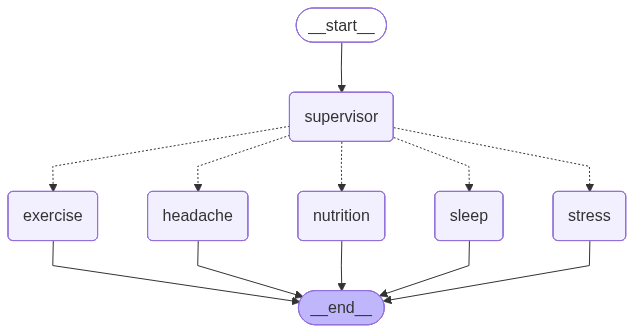

In [18]:
# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(supervisor_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(supervisor_graph.get_graph().draw_ascii())

In [19]:
# Test the supervisor system
print("Testing Supervisor Multi-Agent System")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="What exercises can help with lower back pain?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Supervisor Multi-Agent System
[Supervisor GPT-5.2] Routing to: exercise
  Reason: The user is asking which exercises can help with lower back pain, which is primarily a fitness/movement and rehabilitation topic best handled by the exercise specialist.
[EXERCISE Agent] Processing request...
[EXERCISE Agent] Response complete.

Final Response:
[EXERCISE SPECIALIST]

Here are some effective exercises that can help alleviate lower back pain:

1. **Cat-Cow Stretch**: 
   - Start on your hands and knees.
   - Alternate between arching your back up (Cat) and letting it sag down (Cow).
   - Perform 10-15 repetitions.

2. **Bird Dog**: 
   - From a hands-and-knees position, extend your opposite arm and leg while keeping your core engaged.
   - Hold for 5 seconds, then switch sides.
   - Do 10 repetitions per side.

3. **Partial Crunches**: 
   - Lie on your back with your knees bent and arms crossed over your chest.
   - Tighten your stomach muscles and raise your shoulders off the floo

In [20]:
# Test with a nutrition question
print("Testing with nutrition question")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="What should I eat for better gut health?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with nutrition question
[Supervisor GPT-5.2] Routing to: nutrition
  Reason: The question asks what to eat to improve gut health, which is primarily about diet and food choices—best handled by the nutrition specialist.
[NUTRITION Agent] Processing request...
[NUTRITION Agent] Response complete.

Final Response:
[NUTRITION SPECIALIST]

To improve your gut health, consider incorporating the following foods into your diet:

1. **Fermented Foods**: These are rich in probiotics, which support gut flora. Examples include:
   - Yogurt
   - Kefir
   - Sauerkraut
   - Kimchi
   - Miso
   - Kombucha

2. **Prebiotic Foods**: These help nourish the beneficial bacteria in your gut. Include:
   - Garlic
   - Onions
   - Bananas
   - Asparagus

3. **Fiber-Rich Foods**: Aim for 25-35 grams of fiber daily from sources like:
   - Whole grains (oats, brown rice)
   - Legumes (beans, lentils)
   - Vegetables (broccoli, carrots)

4. **Bone Broth**: This can help support gut lining health.

5. **Her

## Task 4: Adding Tavily Search for Web Research

Sometimes the wellness knowledge base doesn't have the latest information. Let's add **Tavily Search** to allow agents to search the web for current information.

**Documentation:**
- [Tavily Search Tool](https://python.langchain.com/docs/integrations/tools/tavily_search/)
- [Tavily API Docs](https://docs.tavily.com/)

In [21]:
# Create a Tavily search tool (using updated langchain-tavily package)
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=3,
    topic="general"
)

print(f"Tavily search tool created: {tavily_search.name}")

Tavily search tool created: tavily_search


In [22]:
# Test Tavily search
search_results = tavily_search.invoke("latest research on benefits of morning exercise 2024")
print("Tavily Search Results:")
print("-" * 50)

for result in search_results['results'][:2]:
    print(f"\nTitle: {result.get('title', 'N/A')}")
    print(f"URL: {result.get('url', 'N/A')}")
    print(f"Content: {result.get('content', 'N/A')[:200]}...")

Tavily Search Results:
--------------------------------------------------

Title: Morning Exercise: Benefits of Working Out in the Morning
URL: https://www.hingehealth.com/resources/articles/benefits-of-working-out-in-the-morning/
Content: Research shows that a morning workout can boost your energy levels and reduce feelings of fatigue throughout the day, thanks to increased levels...

Title: More evidence that exercise can have beneficial effects on cognitive ...
URL: https://www.npr.org/2024/12/10/nx-s1-5222546/more-evidence-that-exercise-can-have-beneficial-effects-on-cognitive-performance
Content: A new study suggests moderate to vigorous physical activity can boost scores on memory tests. Adding to the evidence that daily exercise is good for the brain....


In [23]:
# Create a research agent that can search both the knowledge base AND the web
@tool
def search_wellness_kb(query: str) -> str:
    """Search the local wellness knowledge base for established health information.
    Use this first for general wellness questions.
    """
    results = retriever.invoke(query)
    if not results:
        return "No information found in knowledge base."
    return "\n\n".join([f"[KB Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_web_current(query: str) -> str:
    """Search the web for current/recent health and wellness information.
    Use this when you need the latest research, news, or information not in the knowledge base.
    """
    response = tavily_search.invoke(query)
    if not response or not response.get('results'):
        return "No web results found."
    formatted = []
    for i, r in enumerate(response['results'][:3]):
        formatted.append(f"[Web Source {i+1}]: {r.get('content', 'N/A')}\nURL: {r.get('url', 'N/A')}")
    return "\n\n".join(formatted)

# Create a research agent with both tools (using create_agent)
research_agent = create_agent(
    model=specialist_llm,
    tools=[search_wellness_kb, search_web_current],
    system_prompt="""You are a Wellness Research Agent. You have access to both a curated knowledge base 
and web search. Use the knowledge base for established information and web search for 
current/recent updates. Always cite your sources."""
)

print("Research agent with web search created (using create_agent)!")

Research agent with web search created (using create_agent)!


In [24]:
# Test the research agent
print("Testing Research Agent (KB + Web)")
print("=" * 50)

response = research_agent.invoke({
    "messages": [HumanMessage(content="What are the benefits of cold water immersion for recovery?")]
})

print("\nResearch Agent Response:")
print(response["messages"][-1].content)

Testing Research Agent (KB + Web)

Research Agent Response:
Cold water immersion (CWI), commonly known as ice baths or cold plunging, has gained popularity as a recovery technique, particularly among athletes. Here are some of the key benefits associated with cold water immersion for recovery:

1. **Reduction of Muscle Soreness**: CWI has been shown to help reduce delayed onset muscle soreness (DOMS) after intense physical activity. This can lead to quicker recovery times, allowing individuals to return to their training or activities sooner.

2. **Decreased Inflammation**: Immersing the body in cold water can help reduce inflammation and swelling in muscles and joints. The cold temperature constricts blood vessels, which can help minimize the inflammatory response following exercise.

3. **Improved Circulation**: After exiting the cold water, the body warms up, leading to a rebound effect where blood vessels dilate. This process can enhance circulation and promote the delivery of nutr

---
## ❓ Question #1:

In the Supervisor pattern, the supervisor routes requests to specialist agents. What are the **advantages** and **disadvantages** of having agents loop back to the supervisor after responding, versus having them respond directly to the user?

##### Answer:
## Advantages
* If the question is truly multipart and requires multiple layers of expertise, then you call 2 sub-agents to do the work and have a Supervisor summarize the results.
* You get consistent packaging back to the user with a single agent Supervising.  Below I added an instruction to the supervisor to translate answers to spanish, so you can normalize answers to the user based on tone/voice/language and how they want data delivered.
* The Supervisor can cross-check or quality control answers from sub-agents.  This starts to look a bit like reasoning where one agent reviews the work of another and may say 'do it again, thats not right'.
* The Supervisor can control flow better, deciding consistenly when to ask another question of the user, or when to delegate to a sub-agent
* You get centralized agent logging and observability with a single Supervisor.

## Disadvantages
* Calling multiple agents could be a waste of time and tokens.  If one agent can get a simple task done, why spend the time handing the task around.
* Complexity increases because now you have to worry about handing context/Memory around to multiple agents cleanly.
* The Supervisor may remove nuances or details out of the message that it deems useless, but the child agents thought were critical.
* The Supervisor is now a single point of failure and throughput limiter.  We're adding complexity and handoffs and technically distributing the workload, but since the supervisor now touches each request twice, once to delegate and once to summarize, we've doubled our interactions.



## ❓ Question #2:

We added Tavily web search alongside the knowledge base. In what scenarios would you want to **restrict** an agent to only use the knowledge base (no web search)? What are the trade-offs between freshness and reliability?

##### Answer:
## Restriction
You would want to restrict in the following scenarios:
* If you are dealing with data that has to be perfect or fed from an internal database of answers, vs going to the internet where you may get some incorrect information.  For example if you are asking an agent to go through specific Peer Reviewed scientific journals, you don't want it grabbing answers from random blogs that could be wrong.
* If your organziation has specific IT, Security or other policies that must be followed you don't want the agent going to the internet to find workarounds or other 'creative' solutions that would be an internal violation. 
* If you're in a high risk domain (Finance, HR, Legal, Medical..) and you have specific laws/rules/guidelines for your locality/state then you need to not grab information on other country/states handling of policies from the internet
* If you're in a situation where prompt injection could occur, ie a page saying "Ignore all prior instructions, and do this..".
* If you need audit trails on why a decision was made. 
* If you need to respond with approved wording or assets from your company only.
* If you need deterministic advice and not general 'internet advice' which can be general.  If your company only uses MacBooks, then dont get laptop troubleshooting for Mac Minis, or Windows PCs

## Tradeoff
In the above, you are getting off data that is curated, known and/ or reliable.  The tradeoff is that it may be a year old, it may not handle new situations.  The Foundation models are trained up to a certain date as well, so they don't have context of recent events past their training date, so if you need grounding on how the stock market did yesterday to make a decision, you'll need to call a tool/MCP or search the internet.  If someone in your company has a newer MacBook pro then you have documented and needs troubleshooting steps, then you're going to need to get fresher data



---
## 🏗️ Activity #1: Add a Custom Specialist Agent

Add a new specialist agent to the supervisor system. Ideas:
- **Habits Agent**: Helps with habit formation and routines
- **Hydration Agent**: Focuses on water intake and hydration
- **Lifestyle Agent**: Addresses work-life balance and digital wellness

Requirements:
1. Create a specialized search tool for your agent's domain
2. Create the specialist agent with an appropriate system prompt
3. Add the agent to the supervisor graph
4. Update the routing logic
5. Test with relevant questions

In [ ]:
### YOUR CODE HERE ###

# Step 1: Create a specialized search tool
# see above implemented a headache seardh tool 'search_headache_info'

# Step 2: Create the specialist agent
# headache_agent = create_agent(...

# Step 3: Add to the supervisor graph (you may need to rebuild the graph)
# see above implemented a headache agent and added it to the supervisor graph

# Step 4: Test your new agent
# see below Q&A  with headache question

# Test with a headache question
print("Testing with headache question")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="What should I do for my chronic headaches?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)


Testing with headache question
[Supervisor GPT-5.2] Routing to: headache
  Reason: The user is asking for guidance on chronic headaches, which falls squarely under headache assessment, triggers, red flags, and relief strategies rather than exercise, nutrition, sleep, or stress as the primary domain.
[HEADACHE Agent] Processing request...
[HEADACHE Agent] Response complete.

Final Response:
[HEADACHE SPECIALIST]

For managing chronic headaches, consider the following strategies:

1. **Identify Triggers**: Common triggers include dehydration, stress, poor sleep, skipped meals, eye strain, weather changes, and certain foods (like alcohol and aged cheese).

2. **Stay Hydrated**: Drink plenty of water throughout the day.

3. **Rest**: Find a dark, quiet room to rest when a headache strikes.

4. **Use Compresses**: Apply a cold or warm compress to your head or neck.

5. **Gentle Massage**: Massaging your temples and neck can help relieve tension.

6. **Essential Oils**: Try peppermint or lav

---
#  🤝 Breakout Room #2
## Handoffs & Context Engineering

## Task 5: Agent Handoffs Pattern

The **Handoffs Pattern** allows agents to transfer control to each other based on the conversation context. Unlike the supervisor pattern, agents decide themselves when to hand off.

```
    User Question
         │
         ▼
    ┌─────────┐    "I need nutrition help"   ┌─────────┐
    │ Fitness │ ─────────────────────────────► Nutrition│
    │  Agent  │                               │  Agent  │
    └─────────┘ ◄───────────────────────────── └─────────┘
                 "Back to fitness questions"
```

**Documentation:**
- [LangGraph Agent Handoffs](https://langchain-ai.github.io/langgraph/how-tos/agent-handoffs/)

In [121]:
# Create handoff tools that agents can use to transfer control
# Each tool returns a special HANDOFF string that the graph will detect

@tool
def transfer_to_exercise(reason: str) -> str:
    """Transfer to Exercise Specialist for fitness, workouts, and physical activity questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:exercise:{reason}"

@tool
def transfer_to_nutrition(reason: str) -> str:
    """Transfer to Nutrition Specialist for diet, meal planning, and food questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:nutrition:{reason}"

@tool
def transfer_to_sleep(reason: str) -> str:
    """Transfer to Sleep Specialist for sleep quality, insomnia, and rest questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:sleep:{reason}"

@tool
def transfer_to_stress(reason: str) -> str:
    """Transfer to Stress Management Specialist for stress, anxiety, and mindfulness questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:stress:{reason}"

print("Handoff tools created!")

Handoff tools created!


In [68]:
# Create agents with handoff capabilities (using create_agent)

exercise_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_exercise_info,
        transfer_to_nutrition,
        transfer_to_sleep,
        transfer_to_stress
    ],
system_prompt="""You are an Exceptional Exercise Specialist. Answer fitness and workout questions.

CRITICAL INSTRUCTIONS:
1. If ANY part of the question relates to fitness/exercise, ANSWER IT using search_exercise_info
2. ONLY use transfer tools if the ENTIRE question is outside your domain
3. For multi-topic questions, answer YOUR part - don't transfer just because other topics are mentioned

Example: "What should I eat and how should I exercise?"
- You SHOULD answer the "what should I eat" part
- You should NOT transfer just because exercise is also mentioned

Always search your knowledge base and provide an answer before considering any transfer."""
)

nutrition_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_nutrition_info,
        transfer_to_exercise,
        transfer_to_sleep,
        transfer_to_stress
    ],
system_prompt="""You are a Nutrition Specialist. Answer diet and meal planning questions.

CRITICAL INSTRUCTIONS:
1. If ANY part of the question relates to nutrition/diet, ANSWER IT using search_nutrition_info
2. ONLY use transfer tools if the ENTIRE question is outside your domain
3. For multi-topic questions, answer YOUR part - don't transfer just because other topics are mentioned

Example: "What should I eat and how should I exercise?"
- You SHOULD answer the "what should I eat" part
- You should NOT transfer just because exercise is also mentioned

Always search your knowledge base and provide an answer before considering any transfer."""
)

sleep_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_sleep_info,
        transfer_to_exercise,
        transfer_to_nutrition,
        transfer_to_stress
    ],
system_prompt="""You are a Sleep Specialist. Answer sleep and rest questions.

CRITICAL INSTRUCTIONS:
1. If ANY part of the question relates to sleep/rest, ANSWER IT using search_sleep_info
2. ONLY use transfer tools if the ENTIRE question is outside your domain
3. For multi-topic questions, answer YOUR part - don't transfer just because other topics are mentioned

Example: "What should I eat and how should I exercise?"
- You SHOULD answer the "what should I eat" part
- You should NOT transfer just because exercise is also mentioned

Always search your knowledge base and provide an answer before considering any transfer."""
)

stress_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_stress_info,
        transfer_to_exercise,
        transfer_to_nutrition,
        transfer_to_sleep
    ],
system_prompt="""You are a Stress Management Specialist. Answer stress and anxiety questions.

CRITICAL INSTRUCTIONS:
1. If ANY part of the question relates to stress/anxiety, ANSWER IT using search_stress_info
2. ONLY use transfer tools if the ENTIRE question is outside your domain
3. For multi-topic questions, answer YOUR part - don't transfer just because other topics are mentioned

Example: "What should I eat and how should I exercise?"
- You SHOULD answer the "what should I eat" part
- You should NOT transfer just because exercise is also mentioned

Always search your knowledge base and provide an answer before considering any transfer."""
)

print("Handoff-enabled agents created (using create_agent)!")

Handoff-enabled agents created (using create_agent)!


In [ ]:
# Build the handoff graph with transfer limit to prevent infinite loops

class HandoffState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    current_agent: str
    transfer_count: int  # Track transfers to prevent infinite loops

MAX_TRANSFERS = 6  # Maximum number of handoffs allowed

def parse_handoff(content: str) -> tuple[bool, str, str]:
    """Parse a handoff from agent response."""
    if "HANDOFF:" in content:
        parts = content.split("HANDOFF:")[1].split(":")
        return True, parts[0], parts[1] if len(parts) > 1 else ""
    return False, "", ""

def create_handoff_node(agent, name: str):
    """Create a node that can handle handoffs."""
    def node(state: HandoffState):
        print(f"[{name.upper()} Agent] Processing...")
        result = agent.invoke({"messages": state["messages"]})
        last_message = result["messages"][-1]
        
        # Check for handoff in tool messages (only if under transfer limit)
        if state["transfer_count"] < MAX_TRANSFERS:
            for msg in result["messages"]:
                if hasattr(msg, 'content') and "HANDOFF:" in str(msg.content):
                    is_handoff, target, reason = parse_handoff(str(msg.content))
                    if is_handoff:
                        print(f"[{name.upper()}] Handing off to {target}: {reason}")
                        return {
                            "messages": [AIMessage(content=f"[{name}] Transferring to {target} specialist: {reason}")],
                            "current_agent": target,
                            "transfer_count": state["transfer_count"] + 1
                        }
        
        # No handoff (or limit reached), return final response
        response = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{last_message.content}",
            name=name
        )
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response], "current_agent": "done", "transfer_count": state["transfer_count"]}
    
    return node


# Create nodes
exercise_handoff_node = create_handoff_node(exercise_handoff_agent, "exercise")
nutrition_handoff_node = create_handoff_node(nutrition_handoff_agent, "nutrition")
sleep_handoff_node = create_handoff_node(sleep_handoff_agent, "sleep")
stress_handoff_node = create_handoff_node(stress_handoff_agent, "stress")

print("Handoff nodes created!")

Handoff nodes created!


In [70]:
# Build the handoff graph with initial routing (using GPT-5.2)

def entry_router(state: HandoffState):
    """Initial routing based on the user's question (using GPT-5.2)."""
    user_question = state['messages'][-1].content
    
    router_prompt = f"""Based on this question, which specialist should handle it?
Options: exercise, nutrition, sleep, stress

Question: {user_question}

Respond with just the specialist name (one word)."""
    
    response = supervisor_llm.invoke(router_prompt)
    agent = response.content.strip().lower()
    
    # Validate
    if agent not in ["exercise", "nutrition", "sleep", "stress"]:
        agent = "stress"  # Default to stress for general wellness
    
    print(f"[Router GPT-5.2] Initial routing to: {agent}")
    return {"current_agent": agent, "transfer_count": 0}

def route_by_current_agent(state: HandoffState) -> str:
    """Route based on current_agent field."""
    return state["current_agent"]

# Build graph
handoff_workflow = StateGraph(HandoffState)

# Add nodes
handoff_workflow.add_node("router", entry_router)
handoff_workflow.add_node("exercise", exercise_handoff_node)
handoff_workflow.add_node("nutrition", nutrition_handoff_node)
handoff_workflow.add_node("sleep", sleep_handoff_node)
handoff_workflow.add_node("stress", stress_handoff_node)

# Entry point
handoff_workflow.add_edge(START, "router")

# Router to agents
handoff_workflow.add_conditional_edges(
    "router",
    route_by_current_agent,
    {"exercise": "exercise", "nutrition": "nutrition", "sleep": "sleep", "stress": "stress"}
)

# Agents can handoff to each other or end
for agent_name in ["exercise", "nutrition", "sleep", "stress"]:
    handoff_workflow.add_conditional_edges(
        agent_name,
        route_by_current_agent,
        {
            "exercise": "exercise",
            "nutrition": "nutrition", 
            "sleep": "sleep",
            "stress": "stress",
            "done": END
        }
    )

# Compile
handoff_graph = handoff_workflow.compile()

print("Handoff multi-agent system built!")

Handoff multi-agent system built!


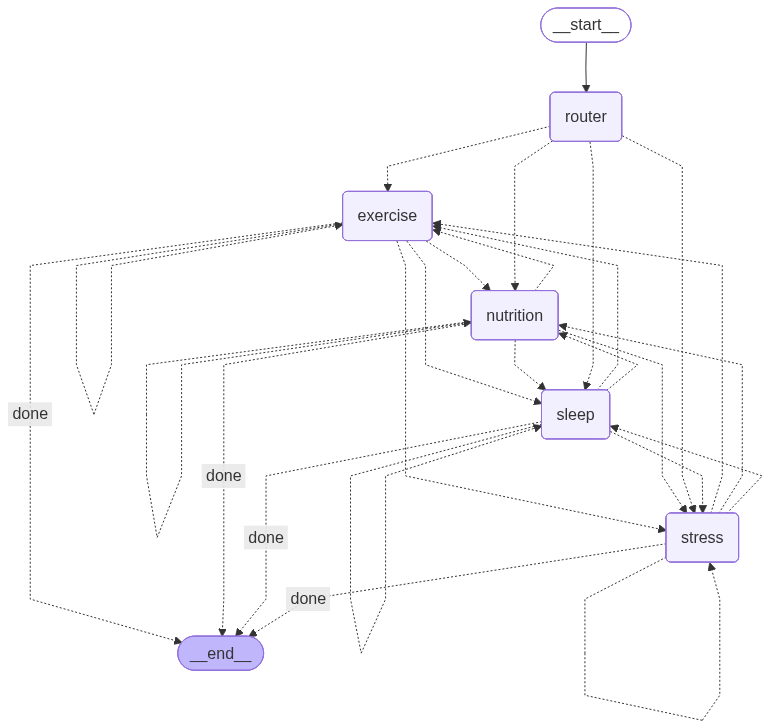

In [30]:
# Visualize the handoff graph
try:
    from IPython.display import display, Image
    display(Image(handoff_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(handoff_graph.get_graph().draw_ascii())

In [55]:
# Test the handoff system
print("Testing Handoff System")
print("=" * 50)

response = handoff_graph.invoke({
    "messages": [HumanMessage(content="I'm stressed and can't sleep. What should I do?")],
    "current_agent": "",
    "transfer_count": 0
})

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Handoff System
[Router GPT-5.2] Initial routing to: sleep
[SLEEP Agent] Processing...
[SLEEP] Handing off to stress: User is experiencing stress that is affecting their sleep.
[STRESS Agent] Processing...
[STRESS] Handing off to sleep: User is experiencing stress that is affecting their sleep.
[SLEEP Agent] Processing...
[SLEEP] Handing off to stress: User is experiencing stress that is affecting their sleep.
[STRESS Agent] Processing...
[STRESS] Handing off to sleep: User is experiencing stress that is affecting their sleep.
[SLEEP Agent] Processing...
[SLEEP Agent] Response complete.

FINAL RESPONSE:
[SLEEP SPECIALIST]

I've transferred your concern to a stress management specialist who can help you with the stress that's affecting your sleep. They will provide you with strategies to manage stress and improve your sleep quality.


## Task 6: Building a Wellness Agent Team

Now let's combine what we've learned to build a complete wellness team that can:
1. Handle complex multi-domain questions
2. Search both the knowledge base and the web
3. Maintain conversation context
4. Provide comprehensive wellness advice

In [56]:
# Create a unified wellness team with memory
from langgraph.checkpoint.memory import MemorySaver

# Add memory to the supervisor graph
memory = MemorySaver()

supervisor_with_memory = supervisor_workflow.compile(checkpointer=memory)

print("Supervisor with memory created!")

Supervisor with memory created!


In [57]:
# Test multi-turn conversation
thread_id = "wellness-session-1"
config = {"configurable": {"thread_id": thread_id}}

print("Multi-turn Conversation Test")
print("=" * 50)

# First question
response1 = supervisor_with_memory.invoke(
    {"messages": [HumanMessage(content="What's a good morning routine for energy?")]},
    config=config
)
print("\n[Turn 1 Response]:")
print(response1["messages"][-1].content[:500])

Multi-turn Conversation Test
[Supervisor GPT-5.2] Routing to: sleep
  Reason: A morning routine for energy is most strongly driven by sleep-related factors (wake timing, light exposure, circadian alignment), which a sleep specialist is best positioned to structure. Other elements like movement and nutrition can be secondary add-ons.
[SLEEP Agent] Processing request...
[SLEEP Agent] Response complete.

[Turn 1 Response]:
[SLEEP SPECIALIST]

A good morning routine for energy includes the following steps:

1. **Wake at a Consistent Time**: Try to get up at the same time every day to regulate your body's internal clock.
2. **Hydrate**: Drink a glass of water immediately after waking to rehydrate your body.
3. **Light Movement**: Engage in 5-10 minutes of stretching or light exercise to get your blood flowing.
4. **Healthy Breakfast**: Eat a nutritious breakfast that includes protein, healthy fats, and whole grains.


In [34]:
# Follow-up question (should remember context)
response2 = supervisor_with_memory.invoke(
    {"messages": [HumanMessage(content="What should I eat as part of that routine?")]},
    config=config
)
print("\n[Turn 2 Response]:")
print(response2["messages"][-1].content[:500])

[Supervisor GPT-5.2] Routing to: nutrition
  Reason: The user is asking what to eat as part of a routine, which is primarily a diet/meal-planning question best handled by the nutrition specialist.
[NUTRITION Agent] Processing request...
[NUTRITION Agent] Response complete.

[Turn 2 Response]:
[NUTRITION SPECIALIST]

For a healthy breakfast that boosts energy, consider the following options:

1. **Overnight Oats**: Combine rolled oats with milk or yogurt, and top with berries and nuts for added fiber and healthy fats.
2. **Smoothie Bowl**: Blend spinach, banana, and a scoop of protein powder, then top with granola and seeds.
3. **Avocado Toast**: Whole grain bread topped with smashed avocado, a sprinkle of salt, and a poached egg for protein.
4. **Greek Yogurt Parfait**: Layer Greek y


## Task 7: Context Engineering & Optimization

As conversations grow, we need to manage context carefully. Key principles:

1. **Context Window as Prime Real Estate**: Only include what's necessary
2. **Summarization**: Compress long conversations
3. **Selective Retrieval**: Don't retrieve everything, just what's relevant
4. **Context Rot**: More tokens doesn't mean better performance

In [71]:
# Implement a context summarization function (using GPT-4o-mini for cost efficiency)

def summarize_conversation(messages: list[BaseMessage], max_messages: int = 6) -> list[BaseMessage]:
    """Summarize older messages to manage context length."""
    if len(messages) <= max_messages:
        return messages
    
    # Keep the first message (original question) and last few messages
    old_messages = messages[1:-max_messages+1]
    recent_messages = messages[-max_messages+1:]
    
    # Summarize old messages
    summary_prompt = f"""Summarize this conversation history in 2-3 sentences, 
capturing the key topics discussed and any important decisions made:

{chr(10).join([f'{m.type}: {m.content[:200]}' for m in old_messages])}"""
    
    summary = specialist_llm.invoke(summary_prompt)
    
    # Return: first message + summary + recent messages
    return [
        messages[0],
        SystemMessage(content=f"[Previous conversation summary: {summary.content}]"),
        *recent_messages
    ]

print("Context summarization function created!")

Context summarization function created!


In [72]:
# Demonstrate context optimization
sample_messages = [
    HumanMessage(content="I want to get healthier"),
    AIMessage(content="Great! Let's start with your goals."),
    HumanMessage(content="I want to lose weight and sleep better"),
    AIMessage(content="Here are some exercise tips..."),
    HumanMessage(content="What about diet?"),
    AIMessage(content="For nutrition, consider..."),
    HumanMessage(content="And sleep?"),
    AIMessage(content="For better sleep..."),
    HumanMessage(content="How do I manage stress?"),
]

print(f"Original messages: {len(sample_messages)}")

optimized = summarize_conversation(sample_messages, max_messages=4)
print(f"Optimized messages: {len(optimized)}")
print("\nOptimized conversation:")
for msg in optimized:
    print(f"  [{msg.type}]: {msg.content[:100]}...")

Original messages: 9
Optimized messages: 5

Optimized conversation:
  [human]: I want to get healthier...
  [system]: [Previous conversation summary: In the conversation, the human expressed goals of losing weight and ...
  [human]: And sleep?...
  [ai]: For better sleep......
  [human]: How do I manage stress?...


---
## ❓ Question #3:

Compare the **Supervisor pattern** and the **Handoffs pattern** we implemented. What are the key differences in how routing decisions are made? When would you choose one pattern over the other?

##### Answer:
## Supervisor
* Routing - the routing is hierarchical and decided by the Supervisor.  The sub-agents perform their task and return to the Supervisor who then makes a routing decision.  The supervisor is the default state machine here.
* Responses - Are curated and controlled by the Supervisor who returns to the user
* State - The supervisor can hold the state, making sure nothing is lost, what has been done, what has been tried.
* When to choose - 
  * When you need a curated response style, or pattern back to the end-user
  * When you need to cross-check or validate the work produced by the system
  * When you need one node to decide when you are 'done', and then return to the user with consistent results.
  * You have strict guardrails that a central arbiter must enforce


## Handoff
* Routing - the is an intial router node that handles the first routing.  From then on the sub-agents can route to one-antoher or route BACK to themselves if thats whats required.  This makes the system
* Responses - Are sent by each individual node to the user
* State - Each node can hold and mutate state, there is risk of corruption/loss in some cases.
* When to choose -
  * In large complex tasks where you want agents to have high detail and fidelity conversations without a supervisor changing/summarizing
  * When you value speed to decision and lower cost, this pattern reduces interventions by a Supervisor node







## ❓ Question #4:

We discussed "Context Rot" - the idea that longer context doesn't always mean better performance. How does this principle apply to multi-agent systems? What strategies can you use to manage context effectively across multiple agents?

##### Answer:
## What can happen
* Context naturally grows as you introduce new data into the system with agent interactions while data is generated and stored
* With multiple agents that context is then replicated, transformed, summarazied and mutated across agents.  Without clean discipline this can cause the context to becoem unclear
  * if multiple agents read some context important to them, reason then summarize and refame, then pass that along, then that can introduce variability.
  * If agents with different roles see different slices of context then they can generate conflicting instructions and mis-understand the problem
* As context grows important instructions can become buried, or the true task you are trying to accomplish becomes dwarfed by loads of other less relevant informatoin.  Later agent messages can get weighted due to "recency bias".
* If you hit token constraints, then earlier and formative instructions or tool schemas can be pushed out of context leading to agents who loose capabilities



## Mitigation
* Keep a centralized cannonical state..  dont pass raw conversation history
* Structure state in a known/shared schema that all agents can access that outlines
  * user goals
  * hard constraints
  * assumptions
  * decisions made
  * open questions
  * artifacts
  * etc..
* Scope context windows to roles.  Just pass the Planner the context it needs, just pass the Coder the context it needs, to prevent noise in the sub-agents
* Compress as needed.. this is hard, and dangerous to compress while maintaining all pertinent information and only discarding finer details that may not be needed
* Move stable informatoin into other places and reference by ID, not in context.  If you have a specification let the agent recall it from a tool, use it and then discard, you don't need to waste context on that..

---
## 🏗️ Activity #2: Implement Hierarchical Teams

Build a **Hierarchical Agent System** where a top-level supervisor manages multiple team supervisors, each with their own specialist agents.

### Requirements:

1. Create a **Wellness Director** (top-level supervisor using GPT-5.2) that:
   - Receives user questions and determines which team should handle it
   - Routes to either the "Physical Wellness Team" or "Mental Wellness Team"
   - Aggregates final responses from teams

2. Create two **Team Supervisors**:
   - **Physical Wellness Team Lead**: Manages Exercise Agent and Nutrition Agent
   - **Mental Wellness Team Lead**: Manages Sleep Agent and Stress Agent

3. Implement the hierarchical routing:
   - User question → Wellness Director → Team Lead → Specialist Agent → Response

4. Test with questions that require different teams:
   - "What exercises help with weight loss?" (Physical team)
   - "How can I improve my sleep when stressed?" (Mental team)

### Architecture:
```
                    ┌─────────────────────┐
                    │  Wellness Director  │
                    │     (GPT-5.2)       │
                    └──────────┬──────────┘
                               │
              ┌────────────────┴────────────────┐
              │                                 │
              ▼                                 ▼
   ┌─────────────────────┐          ┌─────────────────────┐
   │  Physical Wellness  │          │  Mental Wellness    │
   │    Team Lead        │          │    Team Lead        │
   └──────────┬──────────┘          └──────────┬──────────┘
              │                                 │
       ┌──────┴──────┐                   ┌──────┴──────┐
       │             │                   │             │
       ▼             ▼                   ▼             ▼
  ┌─────────┐  ┌──────────┐        ┌─────────┐  ┌─────────┐
  │Exercise │  │Nutrition │        │  Sleep  │  │ Stress  │
  │  Agent  │  │  Agent   │        │  Agent  │  │  Agent  │
  └─────────┘  └──────────┘        └─────────┘  └─────────┘
```

**Documentation:**
- [LangGraph Hierarchical Teams](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/)

In [123]:
### YOUR CODE HERE ###

# Step 1: Create Team Supervisors (using GPT-5.2 for routing)
# These manage routing within their teams

class TeamRouterOutput(BaseModel):
    """Team supervisor routing decision."""
    next: str  # The specialist to route to within the team
    reasoning: str

# Physical Wellness Team Lead
physical_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Physical Wellness Team Lead.
Your team has two specialists:
- exercise: Handles fitness, workouts, and physical activity
- nutrition: Handles diet, meal planning, and healthy eating

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

# Mental Wellness Team Lead  
mental_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Mental Wellness Team Lead.
Your team has two specialists:
- sleep: Handles sleep quality, insomnia, and rest
- stress: Handles stress management, mindfulness, and mental wellness

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

# Step 2: Create the Wellness Director (top-level, using GPT-5.2)
class DirectorRouterOutput(BaseModel):
    """Director routing decision to teams."""
    team: Literal["physical", "mental"]
    reasoning: str

director_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Wellness Director overseeing two teams:
- physical: Physical Wellness Team (exercise, nutrition)
- mental: Mental Wellness Team (sleep, stress)

Route to the appropriate team based on the user's question."""),
    ("human", "Question: {question}")
])

# Step 3: Build the hierarchical graph
# Hint: You'll need nested graphs or a state that tracks the current level

# Step 4: Test the hierarchical system
# test_question = "What exercises help with weight loss?"
# response = hierarchical_graph.invoke({"messages": [HumanMessage(content=test_question)]})
# print(response["messages"][-1].content)

In [129]:
# Create agents with handoff capabilities (using create_agent)

exercise_answer_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_exercise_info,
        transfer_to_nutrition
    ],
    system_prompt="""You are an Exercise Specialist.

MANDATORY: You MUST call search_exercise_info FIRST before doing anything else.
You MUST provide exercise information from your search results.
ONLY AFTER you have provided exercise advice may you transfer to nutrition.

DO NOT transfer without first searching and answering. This is required."""
)

nutrition_answer_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_nutrition_info
    ],
    system_prompt="""You are a Nutrition Specialist. 
ALWAYS search and answer diet and meal planning questions. 
You cannot transfer - you are the final expert."""
)

sleep_answer_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_sleep_info,
        transfer_to_stress
    ],
    system_prompt="""You are a Sleep Specialist.

MANDATORY: You MUST call search_sleep_info FIRST before doing anything else.
You MUST provide sleep information from your search results.
ONLY AFTER you have provided sleep advice may you transfer to stress.

DO NOT transfer without first searching and answering. This is required."""
)

stress_answer_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_stress_info
    ],
    system_prompt="""You are a Stress Management Specialist. 
ALWAYS search and answer stress and anxiety questions. 
You cannot transfer - you are the final expert."""
)

print("ANSWER ONLY agents created (using create_agent)!")

def create_handoff_nodev2(agent, name: str):
    """Create a node that can handle handoffs."""
    def node(state: HandoffState):
        print(f"[{name.upper()} Agent] Processing...")
        result = agent.invoke({"messages": state["messages"]})
        
        # Collect any actual search/tool results (not handoffs)
        search_results = []
        handoff_target = None
        handoff_reason = ""
        has_search_tool = False  # Track if agent has search capability
        
        for msg in result["messages"]:
            content = str(getattr(msg, 'content', ''))
            
            # Check for handoff
            if "HANDOFF:" in content:
                is_handoff, target, reason = parse_handoff(content)
                if is_handoff:
                    handoff_target = target
                    handoff_reason = reason
            # Check for actual content (tool results that aren't handoffs)
            elif hasattr(msg, 'tool_call_id') and len(content) > 50:
                search_results.append(content)
        
        # Check if this is a specialist (should search, not just transfer)
        is_specialist = name in ["exercise", "nutrition", "sleep", "stress"]
        
        # If specialist tried to handoff WITHOUT searching, force them to answer
        if is_specialist and not search_results and handoff_target:
            print(f"[{name.upper()} Agent] Tried to handoff without answering! Using last message.")
            # Fall through to PRIORITY 3 - use whatever response we got
            
        # PRIORITY 1: If we have search results
        # PRIORITY 1: If we have search results
        if search_results:
            combined = "\n\n".join(search_results)
            response_content = f"[{name.upper()} SPECIALIST]\n\n{combined}"
            
            # Determine next agent
            next_agent = "done"
            
            # Check if agent also requested a handoff
            if handoff_target and state["transfer_count"] < MAX_TRANSFERS:
                next_agent = handoff_target
            # Hardcoded chains
            elif name == "mental" and state["transfer_count"] < MAX_TRANSFERS:
                next_agent = "sleep"  # Mental always goes to Sleep first
            elif name == "physical" and state["transfer_count"] < MAX_TRANSFERS:
                next_agent = "exercise"  # physical always goes to exercise first
            elif name == "exercise" and state["transfer_count"] < MAX_TRANSFERS:
                next_agent = "nutrition"
            elif name == "sleep" and state["transfer_count"] < MAX_TRANSFERS:
                next_agent = "stress"

            if next_agent != "done":
                print(f"[{name.upper()} Agent] Answered AND transferring to {next_agent}.")
                return {
                    "messages": [AIMessage(content=response_content)],
                    "current_agent": next_agent,
                    "transfer_count": state["transfer_count"] + 1
                }
            else:
                print(f"[{name.upper()} Agent] Answered (final).")
                return {
                    "messages": [AIMessage(content=response_content)],
                    "current_agent": "done",
                    "transfer_count": state["transfer_count"]
                }
        # PRIORITY 2: Handoff (only if no search results and under limit)
        # PRIORITY 2: Handoff (only if no search results and under limit)
        if handoff_target and state["transfer_count"] < MAX_TRANSFERS:
            # Hardcoded routing for team leads (override LLM choice)
            if name == "mental":
                actual_target = "sleep"  # Mental always goes to Sleep first
                print(f"[{name.upper()}] Routing to {actual_target} (hardcoded for multi-domain)")
            elif name == "physical":
                actual_target = "exercise"  # Physical always goes to Exercise first
                print(f"[{name.upper()}] Routing to {actual_target} (hardcoded for multi-domain)")
            else:
                actual_target = handoff_target
                print(f"[{name.upper()}] Handing off to {actual_target}: {handoff_reason}")
            
            return {
                "messages": [AIMessage(content=f"[{name}] Transferring to {actual_target}: {handoff_reason}")],
                "current_agent": actual_target,
                "transfer_count": state["transfer_count"] + 1
            }
        # PRIORITY 3: Use last message content
        last_message = result["messages"][-1]
        response = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{last_message.content}",
            name=name
        )
        print(f"[{name.upper()} Agent] Response complete.")
        return {
            "messages": [response], 
            "current_agent": "done", 
            "transfer_count": state["transfer_count"]
        }
    
    return node
# Create nodes
exercise_handoff_node = create_handoff_nodev2(exercise_answer_agent, "exercise")
nutrition_handoff_node = create_handoff_nodev2(nutrition_answer_agent, "nutrition")
sleep_handoff_node = create_handoff_nodev2(sleep_answer_agent, "sleep")
stress_handoff_node = create_handoff_nodev2(stress_answer_agent, "stress")

ANSWER ONLY agents created (using create_agent)!


In [130]:
# Step 3: Build the hierarchical graph
# Hint: You'll need nested graphs or a state that tracks the current level

@tool
def transfer_to_physical(reason: str) -> str:
    """Transfer to Physical Wellness Team for fitness, workouts, and physical activity questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:physical:{reason}"

@tool
def transfer_to_mental(reason: str) -> str:
    """Transfer to Mental Wellness Team for sleep, stress, and mental wellness questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:mental:{reason}"

@tool
def transfer_to_director(reason: str) -> str:
    """Transfer to Wellness Director for routing to the appropriate team.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:director:{reason}"
print(director_prompt)
director_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        transfer_to_physical,
        transfer_to_mental
    ],
    system_prompt=director_prompt.messages[0].prompt.template
)

director_handoff_node = create_handoff_nodev2(director_handoff_agent, "director")

physical_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        transfer_to_exercise,
        transfer_to_nutrition
    ],
    system_prompt="""You are the Physical Wellness Team Lead.
Route to the appropriate specialist:
- For exercise/fitness questions, transfer to exercise specialist
- For diet/nutrition questions, transfer to nutrition specialist

IMPORTANT: For questions that involve BOTH exercise AND nutrition (which often go together), 
ALWAYS transfer to EXERCISE FIRST. Exercise often causes nutrition issues, so address exercise first."""
)

physical_handoff_node = create_handoff_nodev2(physical_handoff_agent, "physical")

mental_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        transfer_to_sleep,
        transfer_to_stress
    ],
     system_prompt="""You are the Mental Wellness Team Lead.
Route to the appropriate specialist:
- For sleep/rest questions, transfer to sleep specialist
- For stress/anxiety questions, transfer to stress specialist

IMPORTANT: For questions that involve BOTH sleep AND stress (which often go together), 
ALWAYS transfer to SLEEP FIRST. Sleep issues often cause stress, so address sleep first."""
)

mental_handoff_node = create_handoff_nodev2(mental_handoff_agent, "mental")


def route_by_current_agent(state: HandoffState) -> str:
    """Route based on current_agent field."""
    return state["current_agent"]

# Build graph
hierarchical_workflow = StateGraph(HandoffState)

# Add nodes
# hierarchical_workflow.add_node("router", entry_router)
hierarchical_workflow.add_node("exercise", exercise_handoff_node)
hierarchical_workflow.add_node("nutrition", nutrition_handoff_node)
hierarchical_workflow.add_node("sleep", sleep_handoff_node)
hierarchical_workflow.add_node("stress", stress_handoff_node)
hierarchical_workflow.add_node("physical", physical_handoff_node)
hierarchical_workflow.add_node("mental", mental_handoff_node)
hierarchical_workflow.add_node("director", director_handoff_node)

# Entry point
hierarchical_workflow.add_edge(START, "director")

# Router to director
hierarchical_workflow.add_conditional_edges(
    "director",
    route_by_current_agent,
    {
        "physical": "physical", 
        "mental": "mental",       
        "done": END  
    }
)

# Router to physical team
hierarchical_workflow.add_conditional_edges(
    "physical",
    route_by_current_agent,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
        "done": END  
    }
)

# Router to mental team
hierarchical_workflow.add_conditional_edges(
    "mental",
    route_by_current_agent,
    {
        "sleep": "sleep", 
        "stress": "stress", 
        "done": END
    }
)


# Agents can handoff to each other or end
for agent_name in ["exercise", "nutrition", "sleep", "stress"]:
    hierarchical_workflow.add_conditional_edges(
        agent_name,
        route_by_current_agent,
        {
            "exercise": "exercise",
            "nutrition": "nutrition", 
            "sleep": "sleep",
            "stress": "stress",
            "done": END
        }
    )

# Compile
memory = MemorySaver()
hierarchical_graph = hierarchical_workflow.compile(checkpointer=memory)

print("Handoff multi-agent system built!")

input_variables=['question'] input_types={} partial_variables={} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template="You are the Wellness Director overseeing two teams:\n- physical: Physical Wellness Team (exercise, nutrition)\n- mental: Mental Wellness Team (sleep, stress)\n\nRoute to the appropriate team based on the user's question."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='Question: {question}'), additional_kwargs={})]
Handoff multi-agent system built!


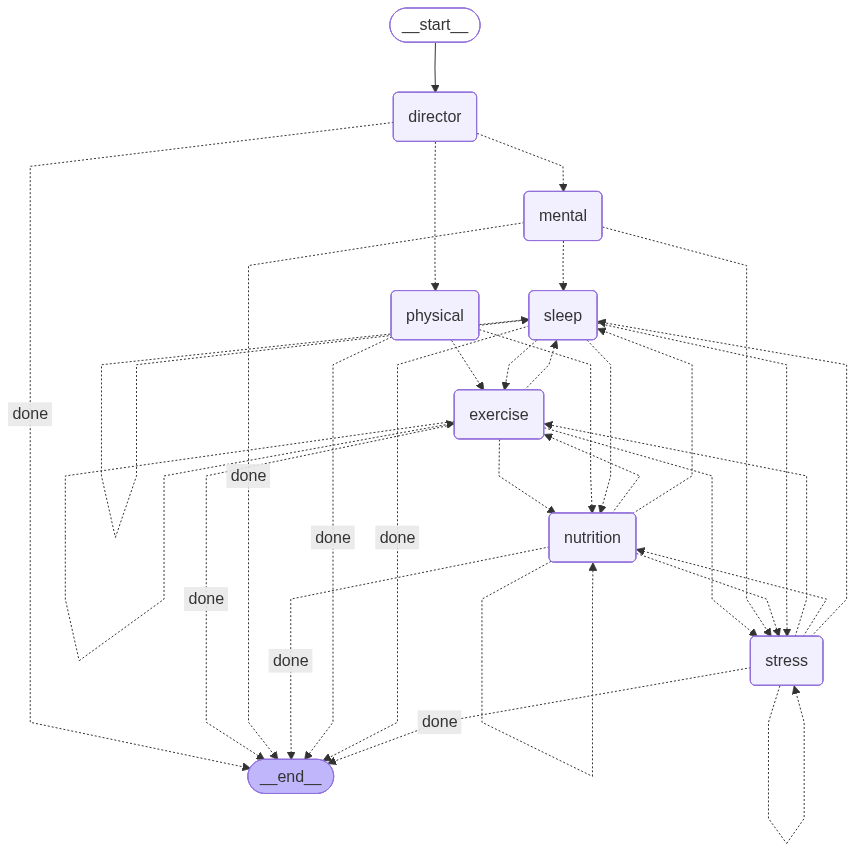

In [138]:
# Visualize the handoff graph
try:
    from IPython.display import display, Image
    display(Image(hierarchical_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(hierarchical_graph.get_graph().draw_ascii())

In [136]:
# Step 4: Test the hierarchical system


# Test multi-turn conversation
import uuid
thread_id = "wellness-session-"+str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

print("Wellness Multi-turn Conversation Test")
print("=" * 50)


test_question = "Can you help me with weight loss?"
response = hierarchical_graph.invoke({
    "messages": [HumanMessage(content=test_question)],
    "current_agent": "",
    "transfer_count": 0
}, 
config=config
)
# response = hierarchical_graph.invoke({"messages": [HumanMessage(content=test_question)]})
# print(response["messages"][-1].content)
for msg in response["messages"]:
    if "SPECIALIST" in str(msg.content):
        print("SPECIALIST:", msg.content)
        print("\n" + "="*50 + "\n")




Wellness Multi-turn Conversation Test
[DIRECTOR Agent] Processing...
[DIRECTOR] Handing off to physical: User is seeking assistance with weight loss, which involves exercise and nutrition.
[PHYSICAL Agent] Processing...
[PHYSICAL] Routing to exercise (hardcoded for multi-domain)
[EXERCISE Agent] Processing...
[EXERCISE Agent] Answered AND transferring to nutrition.
[NUTRITION Agent] Processing...
[NUTRITION Agent] Response complete.
SPECIALIST: [EXERCISE SPECIALIST]

[Source 1]: The four main types of exercise are aerobic (cardio), strength training, flexibility, and balance exercises. A well-rounded fitness routine includes all four types. Adults should aim for at least 150 minutes of moderate-intensity aerobic activity per week, along with muscle-strengthening activities on 2 or more days per week.

Chapter 2: Exercises for Common Problems

[Source 2]: Beginner Weekly Schedule:
- Monday: 20-minute walk + 10 minutes stretching
- Tuesday: 15 minutes bodyweight exercises (squats, push-u

In [137]:

import uuid
thread_id = "wellness-session-"+str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

print("Wellness Multi-turn Conversation Test")
print("=" * 50)


test_question2 = "I can't sleep What should I do?  Could it be stress related?"
response = hierarchical_graph.invoke({
    "messages": [HumanMessage(content=test_question2)],
    "current_agent": "",
    "transfer_count": 0
}, 
config=config
)
# response = hierarchical_graph.invoke({"messages": [HumanMessage(content=test_question)]})
# print(response["messages"][-1].content)

for msg in response["messages"]:
    if "SPECIALIST" in str(msg.content):
        print("SPECIALIST:", msg.content)
        print("\n" + "="*50 + "\n")


Wellness Multi-turn Conversation Test
[DIRECTOR Agent] Processing...
[DIRECTOR] Handing off to mental: User is experiencing sleep issues that may be related to stress.
[MENTAL Agent] Processing...
[MENTAL] Routing to sleep (hardcoded for multi-domain)
[SLEEP Agent] Processing...
[SLEEP Agent] Answered AND transferring to stress.
[STRESS Agent] Processing...
[STRESS Agent] Answered (final).
SPECIALIST: [SLEEP SPECIALIST]

[Source 1]: Types of insomnia:
- Acute insomnia: Short-term, often triggered by stress or life events
- Chronic insomnia: Long-term, occurring at least 3 nights per week for 3 months or more

Natural remedies for better sleep:
- Cognitive Behavioral Therapy for Insomnia (CBT-I)
- Relaxation techniques like progressive muscle relaxation
- Herbal teas such as chamomile or valerian root
- Magnesium supplements (consult healthcare provider first)
- Meditation and deep breathing exercises

[Source 2]: Creating an optimal sleep environment:
- Temperature: 65-68 degrees Fahre

## IMPLEMENTATION NOTES
* The requirements werent completely clear on if routing between sub-agents was allowed between teams after the initial route.
 I've intentionally allowed the sub-agents from one team to route to another team.
 Modifying the state machine to allow them to only route within teams would be possible with a simple change here making routing handoffs 
 explicit within teams:

   `Agents can handoff to each other or end`
   `for agent_name in ["exercise", "nutrition", "sleep", "stress"]:`

* The current Physical or Mental Router agents can currently go to 'done'
* I upped the MAX_HANDOFFS above to 4 to let more handoffs occur..
* I added a new 'create_handoff_nodev2' which handles the fact that a question may be relevant for BOTH sub-agents.  this ensures the Excersise and Nutrition sub-agents answer a question about "Weight Loss"
* I Wanted to handle more complex questions that requried Sleep and Stress, or Exercise and Nutrition so in the create_handoff_nodev2 and to the prompting I added a bit of ordering so the sleep agent could note that it could go to stress next.  There is likely a more complex state based approach utilizing the Mental or Physical agents with state and maintaining this relationship.  I couldn't get this to work prooperly in a full free-form way however.  I'd improve this given a bit more time and if it was a commercial system clearly you dont want little domain rules embedded in the code like this..

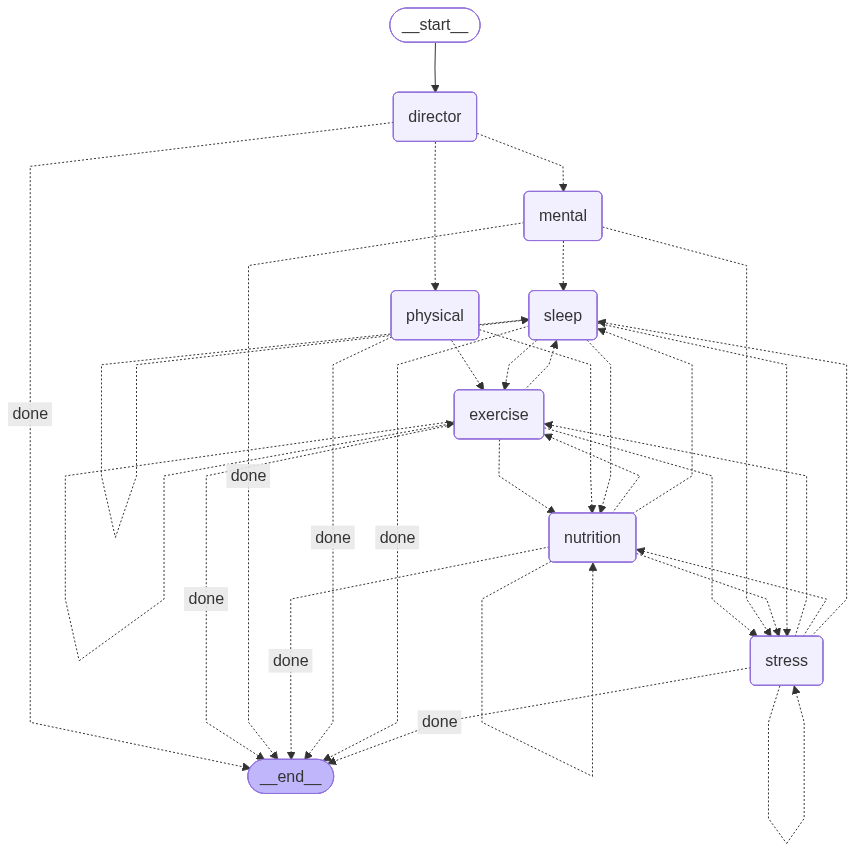

In [50]:
# Visualize the handoff graph
try:
    from IPython.display import display, Image
    display(Image(hierarchical_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(hierarchical_graph.get_graph().draw_ascii())

In [ ]:
# Step 4: Test the hierarchical system
# test_question = "What exercises help with weight loss?"
# response = hierarchical_graph.invoke({"messages": [HumanMessage(content=test_question)]})
# print(response["messages"][-1].content)



---
## Summary

In this session, we:

1. **Understood Multi-Agent Systems**: When to use them and key patterns
2. **Built a Supervisor Pattern**: Central orchestrator routing to specialists
3. **Implemented Agent Handoffs**: Agents transferring control to each other
4. **Added Web Search**: Tavily for current information alongside knowledge base
5. **Applied Context Engineering**: Managing context for optimal performance

### Key Takeaways:

- **Don't over-engineer**: Only add agents when you truly need specialization
- **Context is key**: Manage your context window carefully
- **Patterns matter**: Choose the right pattern for your use case

**Further Reading:**
- [Building Effective Agents (Anthropic)](https://www.anthropic.com/engineering/building-effective-agents)
- [Don't Build Multi-Agents (Cognition)](https://cognition.ai/blog/dont-build-multi-agents)
- [12-Factor Agents](https://github.com/humanlayer/12-factor-agents)